In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset


EPS = 1.0e-7

import torch

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [13]:
results_dir = "."

In [2]:
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

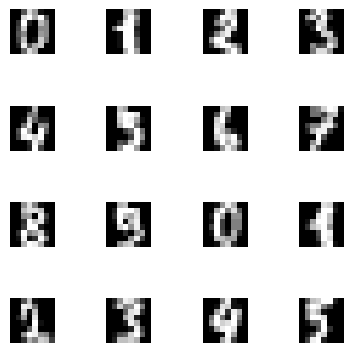

In [3]:
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

In [4]:
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        s = self.classnet(x)
        y_pred = torch.argmax(s, dim=1)

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        y_pred = self.classnet(x)
        loss = self.nll(y_pred, y)
        # ------
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

In [6]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model",weights_only=False)

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

In [7]:
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [8]:
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [9]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [10]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


In [11]:
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped


-> START classifier_mlp
Epoch: 0, val nll=1.0778321838378906, val ce=0.14857142857142858
Epoch: 10, val nll=0.14331938811710904, val ce=0.025714285714285714
Epoch: 20, val nll=0.10324465547289167, val ce=0.03142857142857143
Epoch: 30, val nll=0.0893583505494254, val ce=0.03428571428571429
Epoch: 40, val nll=0.08246384859085083, val ce=0.02857142857142857
Epoch: 50, val nll=0.07650947536740985, val ce=0.025714285714285714
Epoch: 60, val nll=0.07519435831478664, val ce=0.025714285714285714
Epoch: 70, val nll=0.07209715911320277, val ce=0.025714285714285714
Epoch: 80, val nll=0.07068736144474574, val ce=0.025714285714285714
Epoch: 90, val nll=0.06820954969951085, val ce=0.025714285714285714
Epoch: 100, val nll=0.06799301726477487, val ce=0.025714285714285714
Epoch: 110, val nll=0.06753888862473624, val ce=0.025714285714285714
Epoch: 120, val nll=0.06643657343728201, val ce=0.025714285714285714
Epoch: 130, val nll=0.06573103180953435, val ce=0.022857142857142857
Epoch: 140, val nll=0.0649

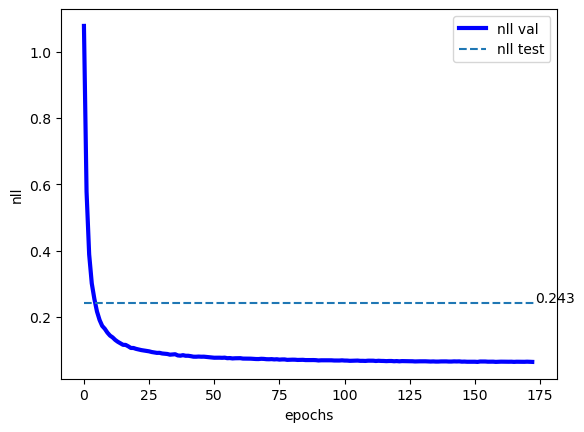

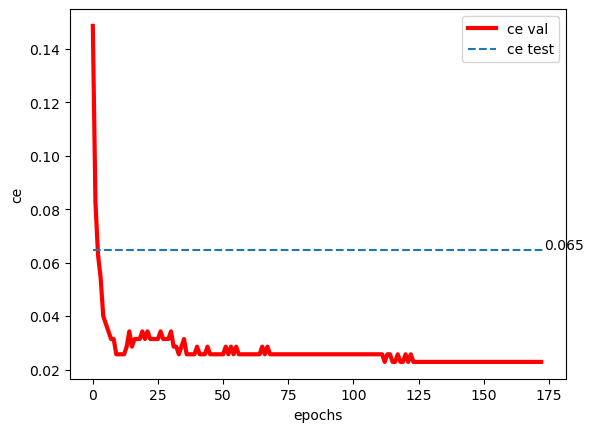


-> START classifier_cnn
Epoch: 0, val nll=1.1565976715087891, val ce=0.18571428571428572
Epoch: 10, val nll=0.14575478213174003, val ce=0.04
Epoch: 20, val nll=0.12041467462267194, val ce=0.03428571428571429
Epoch: 30, val nll=0.11347932270595006, val ce=0.037142857142857144
Epoch: 40, val nll=0.11402337040219988, val ce=0.03428571428571429
Epoch: 50, val nll=0.1121456037248884, val ce=0.03428571428571429
Epoch: 60, val nll=0.11338076932089669, val ce=0.03428571428571429
Epoch: 70, val nll=0.11161730323519026, val ce=0.03142857142857143
Epoch: 80, val nll=0.11190438900675093, val ce=0.03428571428571429
-> FINAL PERFORMANCE: nll=0.23485807817787666, ce=0.06711409395973154


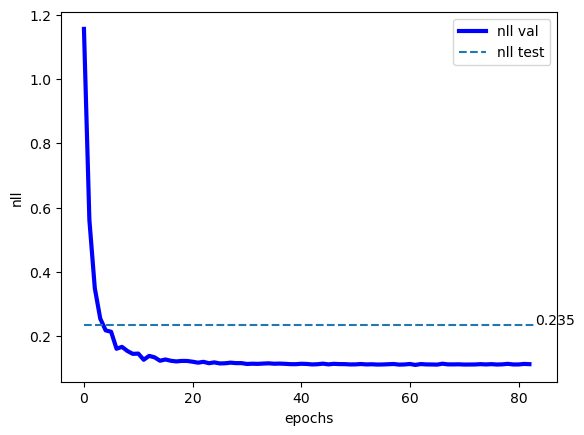

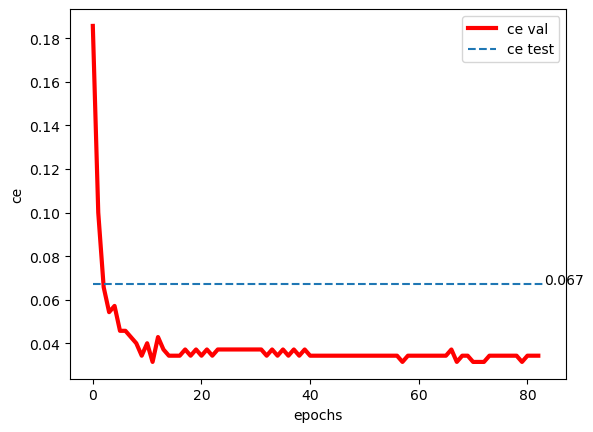

In [14]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            nn.Flatten(),
            nn.Linear(D, M),
            nn.Tanh(),
            nn.Linear(M,M),
            nn.Tanh(),
            nn.Linear(M,K),
            nn.LogSoftmax(1)
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            Reshape((1,8,8)),
            nn.Conv2d(1, num_kernels, 3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d((2,2)),
            Flatten(),
            nn.Linear(num_kernels * 4*4, M),
            nn.Tanh(),
            nn.Linear(M,M),
            nn.Tanh(),
            nn.Linear(M,K),
            nn.LogSoftmax(1),
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

SVHN dataset


In [15]:
dir_train = "/Users/m.manso/Downloads"
name = "ConvNeuralNetwork"
result_dir = "/content/gdrive/My Drive/Colab Notebooks/TEACHING/"
result_dir = os.path.join(results_dir, "results", name + "/")

# =========
# MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
result_dir = "./"  # (current folder)
# =========
if not (os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

In [18]:

class SVHN(Dataset):
    def __init__(self, dir_train, mode="train", transforms=None):
        """
        Here I create the svhn class that when called will download and split the data into train, val and test sets
        """
        self.mode = mode
        self.transforms = transforms

        if mode in ["train", "val"]:
          self.full_data = datasets.SVHN(root=dir_train, split="train", download=True)

          split = int(len(self.full_data) * 0.9)

          train_data, val_data = random_split(self.full_data, [split, len(self.full_data)- split])
          if mode == "train":
            self.data = train_data

          elif mode == "val":
            self.data = val_data

        elif mode == "test":
          self.data = datasets.SVHN(root=dir_train, split="test", download=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        I return the items based on the index and if i need to transform the data
        """
        img, target = self.data[idx]
        if self.transforms != None:
          img = self.transforms(img)
        return (img, target)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) #I initialize the transfromation that needs to occur so from PIL or something else to tensor

# I capture the data and separate variables
train_data = SVHN(dir_train, "train", transforms=transform)
val_data = SVHN(dir_train, "val", transforms=transform)
test_data = SVHN(dir_train, "test", transforms=transform)

#I put it into a dataloader for faster access and batches
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

print(train_data[1][0].shape)

In [ ]:

M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 64  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
class ConvNeuralNetwork(nn.Module):
  def __init__(self):
    """
    The layers I went for is two convolutions to maxpooling to reduce it and get more features and that another time to further increase the features and decrease the picture and then a last convolution to maxpooling to further reduce and increase it I use batch normalisation to make the convolutions converge faster
    Then I flatten everything and use 1 input layer 1 hidden layer and a output layer with dropout to stop overfitting
    """
    super().__init__()
    self.nll = nn.NLLLoss(reduction="none")
    self.stack = nn.Sequential(
            nn.Conv2d(3, num_kernels, 3, padding=1), #channel = 64
            nn.BatchNorm2d(num_kernels),
            nn.ReLU(),
            nn.Conv2d(num_kernels, num_kernels, 3, padding=1), #channel = 64
            nn.BatchNorm2d(num_kernels),
            nn.ReLU(),
            nn.MaxPool2d(2), # 16 * 16

            nn.Conv2d(num_kernels, 2 * num_kernels, 3, padding=1), #channel = 128
            nn.BatchNorm2d(2 * num_kernels),
            nn.ReLU(),
            nn.Conv2d(2 * num_kernels, 2 * num_kernels, 3, padding=1), #channel = 128
            nn.BatchNorm2d(2 * num_kernels),
            nn.ReLU(),
            nn.MaxPool2d(2), # 8 * 8

            nn.Conv2d(2 * num_kernels, 4 * num_kernels, 3, padding=1), #channel = 256
            nn.BatchNorm2d(4 * num_kernels),
            nn.ReLU(),
            nn.MaxPool2d(2), # 4 * 4


            Flatten(),
            nn.Linear((4 * num_kernels) * 4*4, M),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(M,M),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(M,K),
            nn.LogSoftmax(1),
        )
  def classify(self, x):
      s = self.stack(x)
      y_pred = torch.argmax(s, dim=1)

      return y_pred

  def forward(self, x, y, reduction="avg"):
      y_pred = self.stack(x)
      loss = self.nll(y_pred, y)
      if reduction == "sum":
          return loss.sum()
      else:
          return loss.mean()


In [ ]:
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            batch = batch.to(device)#for gpu computations
            targets = targets.to(device)#for gpu computations
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model",weights_only=False)

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        test_batch = test_batch.to(device)#for gpu computations
        test_targets = test_targets.to(device)#for gpu computations
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error

In [ ]:
#I initialize the model
model = ConvNeuralNetwork().to(device)#for gpu computations

#and use a simple adam optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

#then I train the model
nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=train_loader,
        val_loader=val_loader,
    )


#I evaluate the performance on the test set
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)

f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()

plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)